In [ ]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import kagglehub
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import json

In [2]:
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

In [3]:
data = tf.keras.utils.image_dataset_from_directory(path+"\cell_images", labels='inferred', 
                                                   shuffle=True, batch_size = 32, image_size=(224,224))

Found 27558 files belonging to 2 classes.


In [4]:
for image, label in data.take(1):
    print(image[0], 
          "\n---------------------------------------------------------\n",
          label[0], 
          "\n---------------------------------------------------------\n",
          "Shape of image: ", image.shape)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) 
---------------------------------------------------------
 tf.Tensor(0, shape=(), dtype=int32) 
---------------------------------------------------------
 Shape of image:  (32, 224, 224, 3)


In [5]:
# checking assignment of data
for i, val in enumerate(data.class_names):
    print(f"{i} is assigned to {val}")

0 is assigned to Parasitized
1 is assigned to Uninfected


In [6]:
# TEST_SIZE will be just 1 - TRAIN_SIZE - VAL_SIZE
size = len(data)
TRAIN_SIZE = int(0.8*size)  
VAL_SIZE = int(0.1*size)


In [7]:
train_ds = data.take(TRAIN_SIZE)
val_ds = data.skip(TRAIN_SIZE).take(VAL_SIZE)
test_ds = data.skip(TRAIN_SIZE+VAL_SIZE)

In [8]:
for image, label in train_ds.take(1):
    print(image[0], "\n--------------------------------------\n" , "Shape of image: ", image.shape)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) 
--------------------------------------
 Shape of image:  (32, 224, 224, 3)


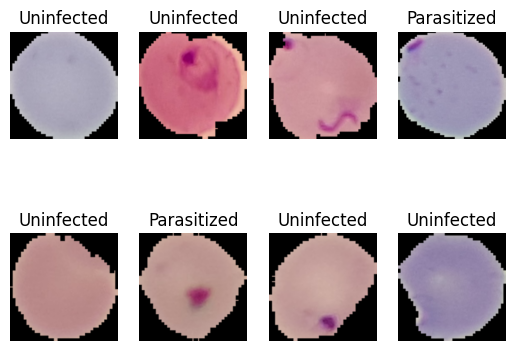

In [9]:
# Let's see some of the samples with labels in order to visualise how malaria infection may look like
for i, (images, labels) in enumerate(train_ds.take(8)):
    ax = plt.subplot(2, 4, i + 1) 
    plt.imshow(images[i].numpy().astype("uint8"))  # showing first pic from each batch
    plt.title(f"{data.class_names[labels[0].numpy()]}")
    plt.axis("off")

In [10]:
def normalize(image, label):
    image = image/255.
    return image, label
AUTOTUNE = tf.data.AUTOTUNE

In [11]:
# Batch_size groups images in te size of Batch
# prefetch enables pre-loading which boost learning process
train_ds = train_ds.map(normalize).prefetch(AUTOTUNE)
val_ds = val_ds.map(normalize).prefetch(AUTOTUNE)
test_ds = test_ds.map(normalize).prefetch(AUTOTUNE)


# Building and training model

In [12]:
model = Sequential()
model.add(InputLayer(shape = (224,224, 3)))
#Conv2D It applies convolutional filters (kernels) to input images
#  to detect local patterns such as edges, textures, and shapes.
model.add(Conv2D(filters=16, kernel_size=3, strides=2, padding='valid', activation='relu'))
# BatchNormalization is a layer that stabilizes and accelerates the training 
# of neural networks by normalizing the inputs of each layer acriss a mini-batch
model.add(BatchNormalization())
#MaxPool2D It reduces the spatial dimensions (height and width)
# of the feature maps, keeping the most important information. (slides a window)
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, strides=2))
# Flatten batch_size(28,28,1) -> batch_size(784)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 111, 111, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 55, 55, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 53, 53, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 53, 53, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,384,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,391,169 (5.31 MB)

 Trainable params: 1,390,913 (5.31 MB)

 Non-trainable params: 256 (1.00 KB)

In [13]:
metrics = [TruePositives(name="tp"), FalsePositives(name="fp"), TrueNegatives(name = "tn"),
            FalseNegatives(name = "fn"), BinaryAccuracy(name='accuracy'),
            Precision(name="precision"), Recall(name = "recall"), AUC(name = "AUC"),
            ]

model.compile(
    optimizer = Adam(learning_rate=10e-3),
    loss = BinaryCrossentropy(),
    metrics = metrics
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience = 3,
    restore_best_weights = True 
)

In [14]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=10,
    verbose=1,
    callbacks = [early_stop]
)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 68s 94ms/step - AUC: 0.7922 - accuracy: 0.7185 - fn: 1346.2957 - fp: 1358.5276 - loss: 0.5379 - precision: 0.7178 - recall: 0.7148 - tn: 4172.1899 - tp: 4178.9404 - val_AUC: 0.9334 - val_accuracy: 0.8928 - val_fn: 152.0000 - val_fp: 143.0000 - val_loss: 0.3377 - val_precision: 0.8952 - val_recall: 0.8894 - val_tn: 1235.0000 - val_tp: 1222.0000
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 72s 104ms/step - AUC: 0.9662 - accuracy: 0.9259 - fn: 350.7623 - fp: 474.0696 - loss: 0.2207 - precision: 0.9164 - recall: 0.9367 - tn: 5057.1392 - tp: 5173.9824 - val_AUC: 0.9116 - val_accuracy: 0.6552 - val_fn: 930.0000 - val_fp: 19.0000 - val_loss: 0.8166 - val_precision: 0.9598 - val_recall: 0.3280 - val_tn: 1349.0000 - val_tp: 454.0000
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 73s 106ms/step - AUC: 0.9772 - accuracy: 0.9453 - fn: 229.2435 - fp: 363.8464 - loss: 0.1726 - precision: 0.9347 - recall: 0.9571 - tn: 5166.7725 - tp: 5296.0913 - val_AUC: 0.9794 - val_accur

In [15]:
# saving model
model.save("malaria_detection.keras")
# saving history
with open("history.json", "w") as f:
    json.dump(history.history, f)

# Loading model

In [16]:
with open("history.json", "r") as f:
    history = json.load(f)
model = load_model("malaria_detection.keras")

In [17]:
history["loss"]

[0.3880123496055603,
 0.21940991282463074,
 0.16634641587734222,
 0.15882784128189087,
 0.16564728319644928,
 0.1454082876443863,
 0.13752514123916626,
 0.13205376267433167]

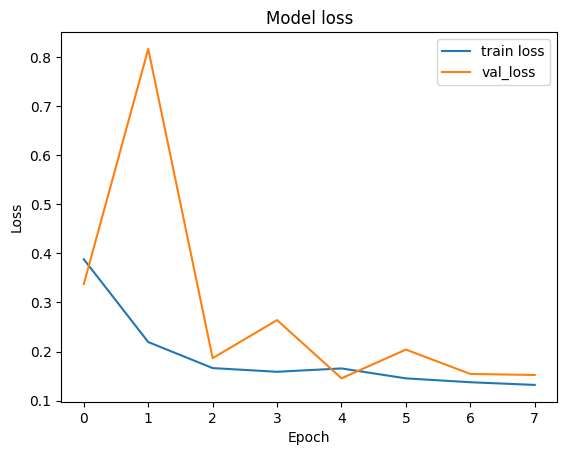

In [18]:
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train loss", "val_loss"])
plt.show()

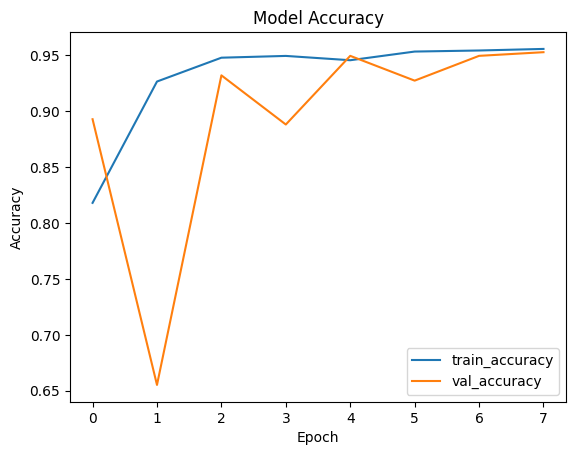

In [19]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

In [20]:
model.evaluate(test_ds)

87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 0.9835 - accuracy: 0.9530 - fn: 30.1591 - fp: 37.1364 - loss: 0.1503 - precision: 0.9535 - recall: 0.9578 - tn: 649.3182 - tp: 706.4318


[0.15088658034801483,
 1324.0,
 78.0,
 1302.0,
 54.0,
 0.9521392583847046,
 0.9443652033805847,
 0.9608127474784851,
 0.9816721677780151]

In [21]:
def parasite_or_not(x):
    if x<0.5:
        return str('P')
    else:
        return str("U")

In [22]:
print(parasite_or_not(model.predict(test_ds.take(1))[0][0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
P


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


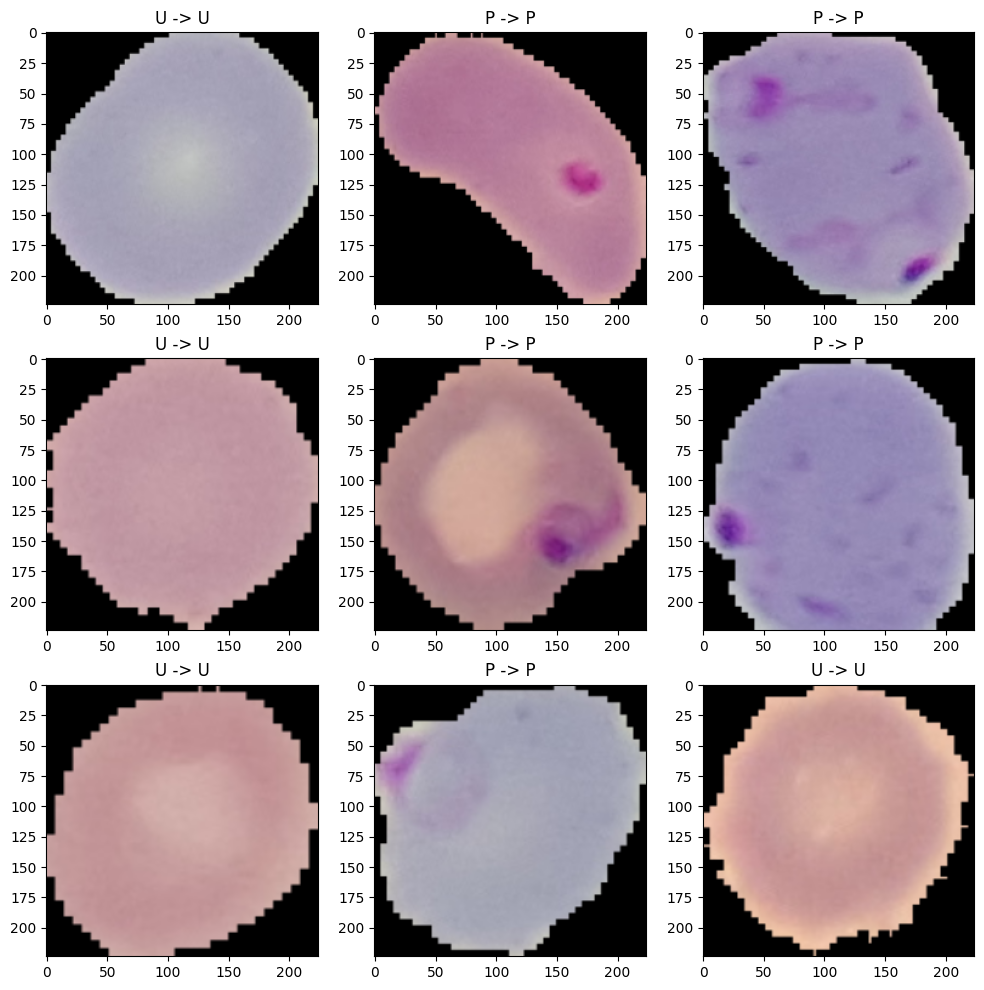

In [23]:
plt.figure(figsize=(12,12))
for image,label in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image[i])
        plt.title(parasite_or_not(label.numpy()[i])+" -> "+parasite_or_not(model.predict(image)[i][0]))

# Building Confusion Matrix

In [ ]:
y_true = []
y_pred = []
y_probs = []
for images, labels in test_ds:
    # Propabilities of image containing malaria
    probs = model.predict(images)
    # Swapping propabilities into real predictions, probs > 0.5 -> bool (np.array), 
    preds = (probs>0.5).astype(int).reshape(-1)
    # Appending each label as numpy item to y_true
    y_true.extend(labels.numpy())
    y_pred.extend(preds)
    y_probs.extend(probs.ravel())

y_pred = np.array(y_pred)
y_true = np.array(y_true)
cm = confusion_matrix(y_true, y_pred)

<Axes: >

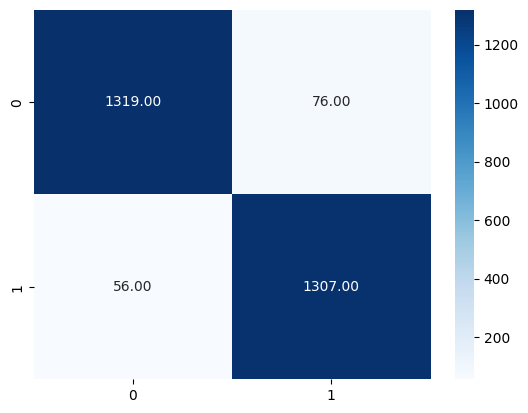

In [25]:
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues")

# Building ROC_curve

In [26]:
fp, tp, thresholds = roc_curve(y_true, y_probs)

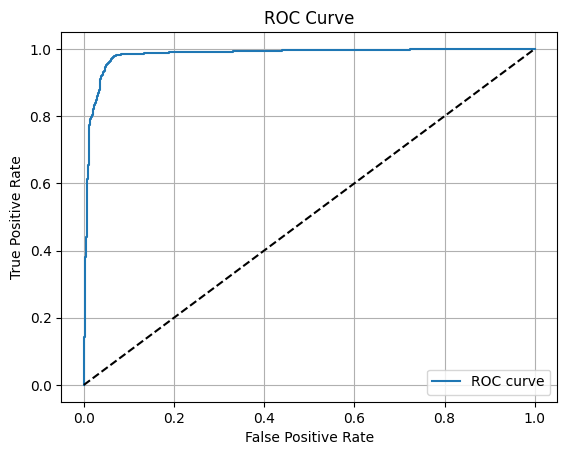

In [27]:
plt.plot(fp, tp, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()